# Overview

In this notebook, we will setup a simple variational autoencoder model and train it on the MNIST dataset.  We will then evaluate the model with some visualizations to test how well it has learned the data distribution.

In [1]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

import os, sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

In [2]:
def load_dataset(data_path):
    import gzip
    def load_mnist_images(filename):
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        data = data.reshape(-1, 28*28)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images(os.path.join(data_path,'train-images-idx3-ubyte.gz'))
    y_train = load_mnist_labels(os.path.join(data_path,'train-labels-idx1-ubyte.gz'))
    X_test = load_mnist_images(os.path.join(data_path,'t10k-images-idx3-ubyte.gz'))
    y_test = load_mnist_labels(os.path.join(data_path,'t10k-labels-idx1-ubyte.gz'))

    return X_train, y_train, X_test, y_test

# load the data
data_path = '../data/MNIST'
X_train, y_train, X_test, y_test = load_dataset(data_path)

image_dim = 784 # MNIST images are 28x28 pixels

# build vae model

### First create all weights

In [3]:
tf.reset_default_graph()

hidden_dim = 256
latent_dim = 2

# functions for initializations also known as inits
def he_init(shape):
    """He inits are designed for neural networks that employ ReLU activations."""
    stddev = np.sqrt(2.6/shape[0])
    return tf.truncated_normal(shape=shape, mean=0.0, stddev=stddev, dtype=tf.float32)


# Variables
weights = {
    'encode': tf.Variable(he_init([image_dim, hidden_dim])),
    'z_mean': tf.Variable(he_init([hidden_dim, latent_dim])),
    'z_std': tf.Variable(he_init([hidden_dim, latent_dim])),
    'decode': tf.Variable(he_init([latent_dim, hidden_dim])),
    'out': tf.Variable(he_init([hidden_dim, image_dim]))
}
biases = {
    'encode': tf.Variable(he_init([hidden_dim])),
    'z_mean': tf.Variable(he_init([latent_dim])),
    'z_std': tf.Variable(he_init([latent_dim])),
    'decode': tf.Variable(he_init([hidden_dim])),
    'out': tf.Variable(he_init([image_dim]))
}

### now lets build the model

In [4]:
# input image
inputs = tf.placeholder(tf.float32, shape=[None, image_dim])

# encoder layer
encoder = tf.matmul(inputs, weights['encode']) + biases['encode']
encoder = tf.nn.relu(encoder)

# latent embedding layer
z_mean = tf.matmul(encoder, weights['z_mean']) + biases['z_mean']
z_std = tf.matmul(encoder, weights['z_std']) + biases['z_std']
z_std = tf.sqrt(tf.square(z_std)+1e-7)   # encorce Z_std is positive

# sample latent variables
noise = tf.random_normal(shape=tf.shape(z_mean), mean=0, stddev=1.0)
Z = z_mean + z_std * noise

# decoder layer
decoder = tf.matmul(Z, weights['decode']) + biases['decode']
decoder = tf.nn.relu(decoder)

# output layer
output = tf.matmul(decoder, weights['out']) + biases['out']
X_sample = tf.nn.sigmoid(output)

### calculate the evidence lower bound (objective function)

In [5]:
# Reconstruction loss
recon_loss = inputs * tf.log(X_sample + 1e-7) + (1-inputs)*tf.log(1-X_sample + 1e-7)
reconstruction_loss = -tf.reduce_sum(recon_loss, axis=1)

# KL Divergence loss
kl_loss = 1 + z_std - tf.square(z_mean) - tf.exp(z_std)
kl_div_loss = -0.5 * tf.reduce_sum(kl_loss, axis=1)

# (variational) evidence lower bound
elbo = tf.reduce_mean(reconstruction_loss + kl_div_loss)

### setup an optimizer

In [6]:
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_step = optimizer.minimize(elbo)

# Now let's train the vae model

### start a session

In [7]:
# Start a session
sess = tf.Session()

# Initialize the variables
sess.run(tf.global_variables_initializer())

### create a batch generator

In [8]:
def batch_generator(X, batch_size=128, shuffle=True):
    """function to generate mini-batches of the data"""
    if shuffle:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
    for start_idx in range(0, len(X)-batch_size+1, batch_size):
        if shuffle:
            excerpt = indices[start_idx:start_idx+batch_size]
        else:
            excerpt = slice(start_idx, start_idx+batch_size)
        yield X[excerpt].astype(np.float32)
        

### iteratively train the vae model

We need to train for a little while (15 minutes or so)

In [20]:
num_epochs = 250
batch_size = 128

num_train_batches = X_train.shape[0] // batch_size

for epoch in range(num_epochs):
    weight = 1 - np.exp(-epoch * 0.05)

    # make a batch ganerator for the training data
    train_batches = batch_generator(X_train, batch_size, shuffle=True)

    # loop over training batches
    train_loss = 0
    for index in range(num_train_batches):
        
        # update over a mini-batch
        feed_dict = {inputs: next(train_batches)}
        
        _, loss = sess.run([train_step, elbo], feed_dict=feed_dict)

        train_loss += loss
        
    print('Epoch %i, Loss: %f' % (epoch, train_loss/num_train_batches))

Epoch 0, Loss: 134.330529
Epoch 1, Loss: 134.386791
Epoch 2, Loss: 134.300554
Epoch 3, Loss: 134.370460
Epoch 4, Loss: 134.306174
Epoch 5, Loss: 134.296615
Epoch 6, Loss: 134.201671
Epoch 7, Loss: 134.249629
Epoch 8, Loss: 134.214240
Epoch 9, Loss: 134.208230
Epoch 10, Loss: 134.167860
Epoch 11, Loss: 134.190861
Epoch 12, Loss: 134.169125
Epoch 13, Loss: 134.118601
Epoch 14, Loss: 134.135199
Epoch 15, Loss: 134.038191
Epoch 16, Loss: 134.087297
Epoch 17, Loss: 134.037042
Epoch 18, Loss: 134.053320
Epoch 19, Loss: 134.032651
Epoch 20, Loss: 134.000316
Epoch 21, Loss: 134.025568
Epoch 22, Loss: 134.002580
Epoch 23, Loss: 133.973456
Epoch 24, Loss: 133.899800
Epoch 25, Loss: 133.906364
Epoch 26, Loss: 133.887808
Epoch 27, Loss: 133.928946
Epoch 28, Loss: 133.837125
Epoch 29, Loss: 133.863411
Epoch 30, Loss: 133.815670
Epoch 31, Loss: 133.850261
Epoch 32, Loss: 133.804668
Epoch 33, Loss: 133.784929
Epoch 34, Loss: 133.727025
Epoch 35, Loss: 133.778585
Epoch 36, Loss: 133.761558
Epoch 37, L

KeyboardInterrupt: 

### save model parameters

In [21]:
# path to save results
save_path = '../results/MNIST'
if not os.path.isdir(save_path):
    os.mkdir(save_path)
    print("making directory: " + save_path)
params_path = os.path.join(save_path, 'simple_vae')

saver = tf.train.Saver()
saver.save(sess, save_path=params_path)

'../results/MNIST/simple_vae_best'

# Evaluate VAE

### let's load the model parameters

In [22]:
# restore model parameters
save_path = '../results/MNIST'
params_path = os.path.join(save_path, 'simple_vae_best')

saver = tf.train.Saver()
saver.restore(sess, save_path=params_path)

INFO:tensorflow:Restoring parameters from ../results/MNIST/simple_vae_best


### Let's sample the latent space about points that real data map to

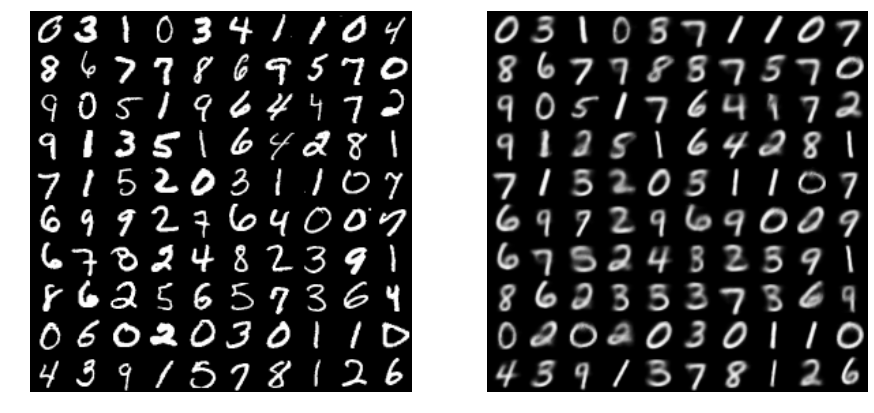

In [23]:
num_grid = 10
num_test = X_test.shape[0]

# get random indices of test data
shuffle = np.random.permutation(num_test)[:num_grid*num_grid]

# generate new images from latent space about test samples
samples = sess.run(X_sample, feed_dict={inputs: X_test[shuffle]})

# plot the original test samples and the generated test samples
fig = plt.figure()
ax = plt.subplot(1,2,1);
ax.imshow((X_test[shuffle].reshape(num_grid, num_grid, 28, 28)
                   .transpose(0, 2, 1, 3)
                   .reshape(num_grid*28, num_grid*28)), cmap='gray')
ax.axis('off')
ax = plt.subplot(1,2,2);
ax.imshow((samples.reshape(num_grid, num_grid, 28, 28)
                   .transpose(0, 2, 1, 3)
                   .reshape(num_grid*28, num_grid*28)), cmap='gray')
ax.axis('off')
fig.set_size_inches(15,15)

### Let's visualize where each number maps to in the latent space

In [24]:
num_test_batches = X_test.shape[0] // batch_size
test_batches = batch_generator(X_test, batch_size, shuffle=False)
z_coord = []
for index in range(num_test_batches):    
    z_coord.append(sess.run(z_mean, feed_dict={inputs: next(test_batches) }))
z_coord = np.vstack(z_coord)

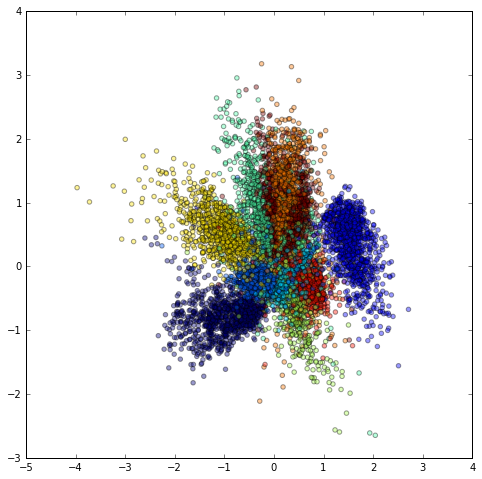

In [25]:
# perform PCA on latent space if more than 2 latent variables
if z_coord.shape[1] > 2:
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    z_reduce = pca.fit_transform(z_coord)
else:
    z_reduce = z_coord

# plot latent space coordinates of each data point
plt.figure(figsize=(8,8))
plt.scatter(z_reduce[:,0], z_reduce[:,1], c=y_test[:z_reduce.shape[0]].astype(int), cmap='jet',alpha=.4);

### visualize the manifold of the latent variables (if 2 dimensional latent variable)

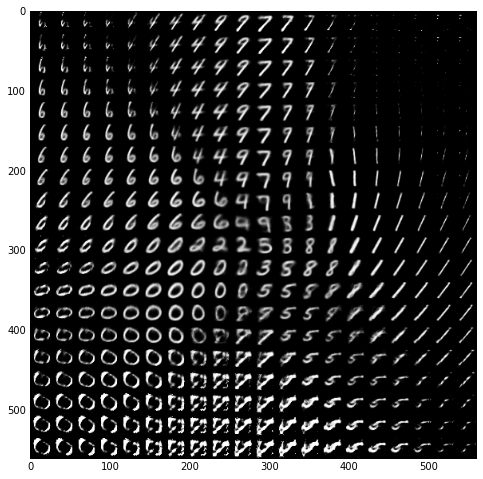

In [26]:

# Rebuild the decoder with a placeholder
noise_input = tf.placeholder(tf.float32, shape=[None, latent_dim])
gen_decoder = tf.matmul(noise_input, weights['decode']) + biases['decode']
gen_decoder = tf.nn.relu(gen_decoder)
gen_decoder = tf.matmul(gen_decoder, weights['out']) + biases['out']
gen_decoder = tf.nn.sigmoid(gen_decoder)


# Building a manifold of generated digits
n = 20

# setup coordinate grid to sample
xMIN = -3
xMAX = 3
yMIN = -3
yMAX = 3
x_axis = np.linspace(xMIN, xMAX, n)
y_axis = np.linspace(yMIN, yMAX, n)

# loop over each 
canvas = np.empty((28 * n, 28 * n))
for i, yi in enumerate(x_axis):
    for j, xi in enumerate(y_axis):
        
        # set coordinates of latent variables
        sample = np.array([[xi, yi]] * batch_size)
        
        # sample an image
        gen_img = sess.run(gen_decoder, feed_dict={noise_input: sample})

        # place generated image onto a canvas
        canvas[(n-i-1)*28:(n-i)*28, j*28:(j+1)*28] = gen_img[0].reshape(28, 28)

# plot manifold
plt.figure(figsize=(8, 10))
Xi, Yi = np.meshgrid(x_axis, y_axis)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()

The manifold is only smooth where the latent variables have been mapped to (see the figure of the latent coordinates for each class above).  